In [1]:
from models.regressionnet_resnet import *
from scripts import tools
from scripts import dataset
from scripts.config import *
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import cv2
import pandas as pd

%matplotlib inline

tools.etc.set_GPU("0")

joints = ['Right Ankle', 'Right Knee', 'Right Hip', 'Left Hip', 'Left Knee', 'Left Ankle',
          'Right Wrist', 'Right Elbow', 'Right Shoulder', 'Left Shoulder', 'Left Elbow', 'Left Wrist',
          'Neck', 'Head']

class_color = ['red','orange','green','blue','purple',
               'aqua','brown','navy','magenta','lightseagreen']
               
classes = ['Sleeping','Reclining','Seated.quiet','Standing.Relaxed','Reading.seated',
              'Writing', 'Typing', 'Filing.Seated','Filing.Stand','Walking about']

sticks = ['Head','Torso','U Arm','L Arm','U Leg','L Leg','Mean']

In [2]:
net = Regressionnet(data_shape=(128,128,3),num_joints=14,gpu_memory_fraction=None, phase='inference')  

with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./snapshots/20181105_Resnet_128_72/Regressionnet_highest_pcp.ckpt")
    
    test_it = dataset.met("./dataset/MET6/met5_allcoor_test.csv", Bbox=True, Bbox_mode='apply', scale_set=[1.0],
                          re_img_size=(128,128), dataset_root="./dataset/MET6/", Shuffle=False, normalize=True)
    
orig_img_set = dataset.met("./dataset/MET6/met5_allcoor_test.csv", Bbox=True, Bbox_mode='apply', scale_set=[1.0],
                           re_img_size=(128,128), dataset_root="./dataset/MET6/", Shuffle=False, normalize=False).img_set

INFO:tensorflow:Restoring parameters from ./snapshots/20181105_Resnet_128_72/Regressionnet_highest_pcp.ckpt


[ {{BBOX}} Applying Images & Coordinates]: 100%|██████████| 50/50 [00:00<00:00, 3335.32it/s]


In [3]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0, net.is_train: False})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set.reshape(-1,14,2))

In [4]:
class_pred_result = [[] for i in range(10)]
class_orig_result = [[] for i in range(10)]

for i in range(len(pred_canonical)):
    class_pred_result[test_it.labels.squeeze()[i]].append(pred_canonical[i])
    class_orig_result[test_it.labels.squeeze()[i]].append(orig_canonical[i])
    
class_pred_result = np.array(class_pred_result)
class_orig_result = np.array(class_orig_result)

pcp_result = []

for i in range(len(class_pred_result)):
    pcp_value = tools.pose.eval_strict_pcp(class_orig_result[i],class_pred_result[i])
    pcp_result.append(tools.pose.average_pcp_left_right_limbs(pcp_value))
    
pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical)
pcp_result.append(tools.pose.average_pcp_left_right_limbs(pcp_value))

pcp_result = np.array(pcp_result)[:,0]
pcp_result = np.array([round(float(v),2) for v in pcp_result.reshape(-1)]).reshape(11,7)

pcp_table = pd.DataFrame(pcp_result.transpose(1,0))
pcp_table.index = sticks
pcp_table.columns = classes + ['Average']

pcp_table

,Sleeping,Reclining,Seated.quiet,Standing.Relaxed,Reading.seated,Writing,Typing,Filing.Seated,Filing.Stand,Walking about,Average
Head,0.20,0.60,1.00,0.60,0.60,0.80,0.80,0.80,0.40,0.60,0.64
Torso,0.40,0.80,1.00,1.00,1.00,1.00,1.00,1.00,0.80,0.80,0.88
U Arm,0.20,0.50,1.00,0.80,1.00,1.00,0.80,0.80,0.60,0.40,0.71
L Arm,0.20,0.40,0.90,0.70,0.70,1.00,0.70,0.80,0.60,0.30,0.63
U Leg,0.40,0.70,1.00,0.80,0.80,1.00,1.00,0.80,0.80,0.90,0.82
L Leg,0.20,0.70,1.00,0.70,1.00,1.00,1.00,1.00,0.80,0.80,0.82
Mean,0.27,0.62,0.98,0.77,0.85,0.97,0.88,0.87,0.67,0.63,0.75


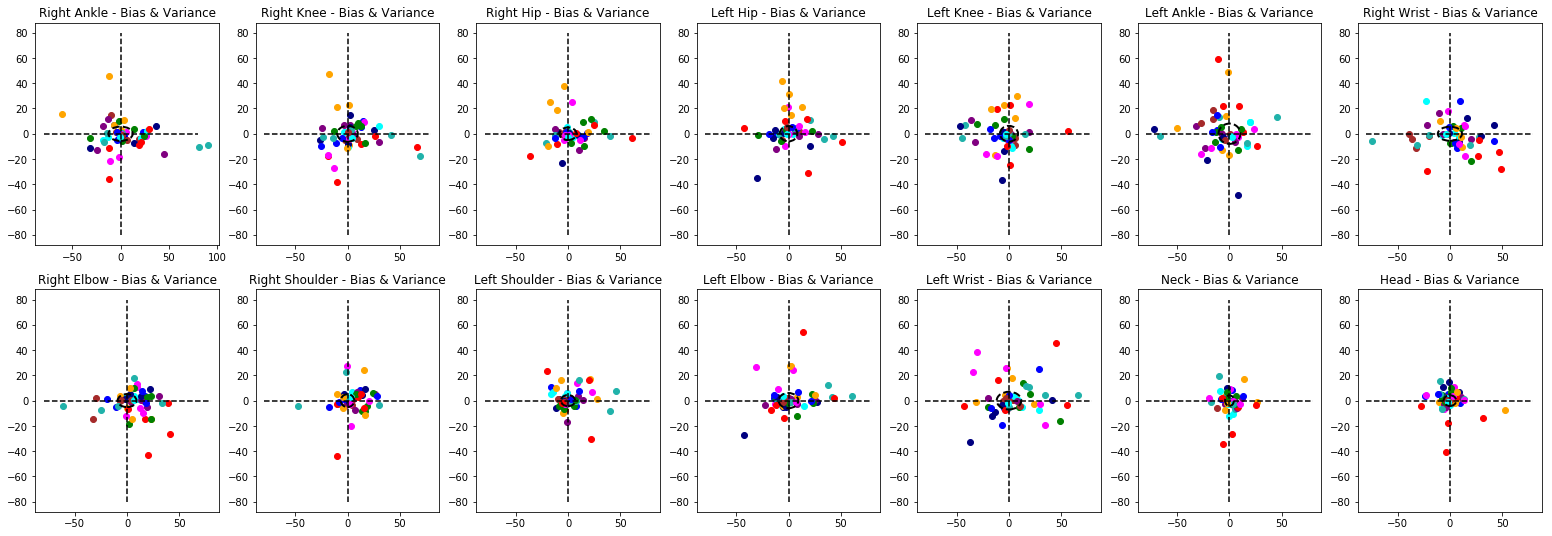

In [5]:
fig, points = plt.subplots(2,7)
fig.set_size_inches(27, 9)

classes_joints = [[predicted_joints] for i in range(len(joints))]

for idx in range(len(joints)):
    x_error = predicted_joints[:,idx,0]-test_it.coor_set[:,idx,0]
    y_error = predicted_joints[:,idx,1]-test_it.coor_set[:,idx,1]
    
    points[idx//7][idx%7].set_title(joints[idx]+' - Bias & Variance')
    points[idx//7][idx%7].plot(np.linspace(-80, 80), np.linspace(0, 0), linestyle='--', c='black')
    points[idx//7][idx%7].plot(np.linspace(0, 0), np.linspace(-80, 80), linestyle='--', c='black')
    points[idx//7][idx%7].add_artist(Ellipse((0,0),x_error.std(),y_error.std(),
                                             linewidth=2,linestyle='--', fill=False))
    
    for i, label in enumerate(test_it.labels.squeeze()):
        points[idx//7][idx%7].scatter(predicted_joints[i,idx,0]-test_it.coor_set[i,idx,0],
                                      predicted_joints[i,idx,1]-test_it.coor_set[i,idx,1],c=class_color[label])

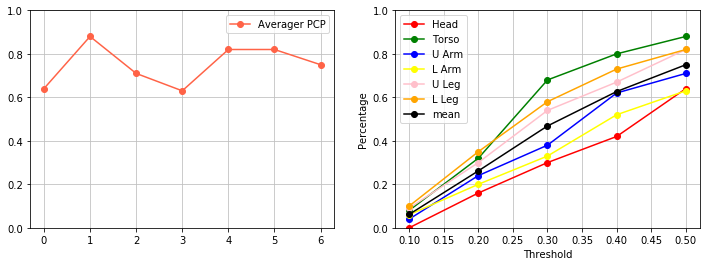

In [6]:
pcp = [[] for _ in range(7)]

for thresh in [0.1,0.2,0.3,0.4,0.5]:
    pcp_value=tools.pose.eval_strict_pcp(orig_canonical,pred_canonical,thresh)
    average_pcp = tools.pose.average_pcp_left_right_limbs(pcp_value)
    for i in range(len(average_pcp[1])):
        pcp[i].append(average_pcp[0][i])
        
fig, pcp_plot = plt.subplots(1,2)
fig.set_size_inches(12,4)

pcp_plot[0].plot(pcp_result[-1], marker='o',c='tomato')
pcp_plot[0].set_ylim(0.0,1.0)
pcp_plot[0].grid(b=True, which='major',c='silver')
pcp_plot[0].legend(['Averager PCP'], loc=1,)

for i, c in enumerate(['red','green','blue','yellow','pink','orange','black']):    
    pcp_plot[1].plot([0.1,0.2,0.3,0.4,0.5],pcp[i],c=c,marker='o')
pcp_plot[1].set_xlabel('Threshold')
pcp_plot[1].set_ylabel('Percentage')
pcp_plot[1].set_ylim(0.0,1.0)
pcp_plot[1].legend(average_pcp[1], loc=2,)
pcp_plot[1].grid(b=True, which='major',c='silver')

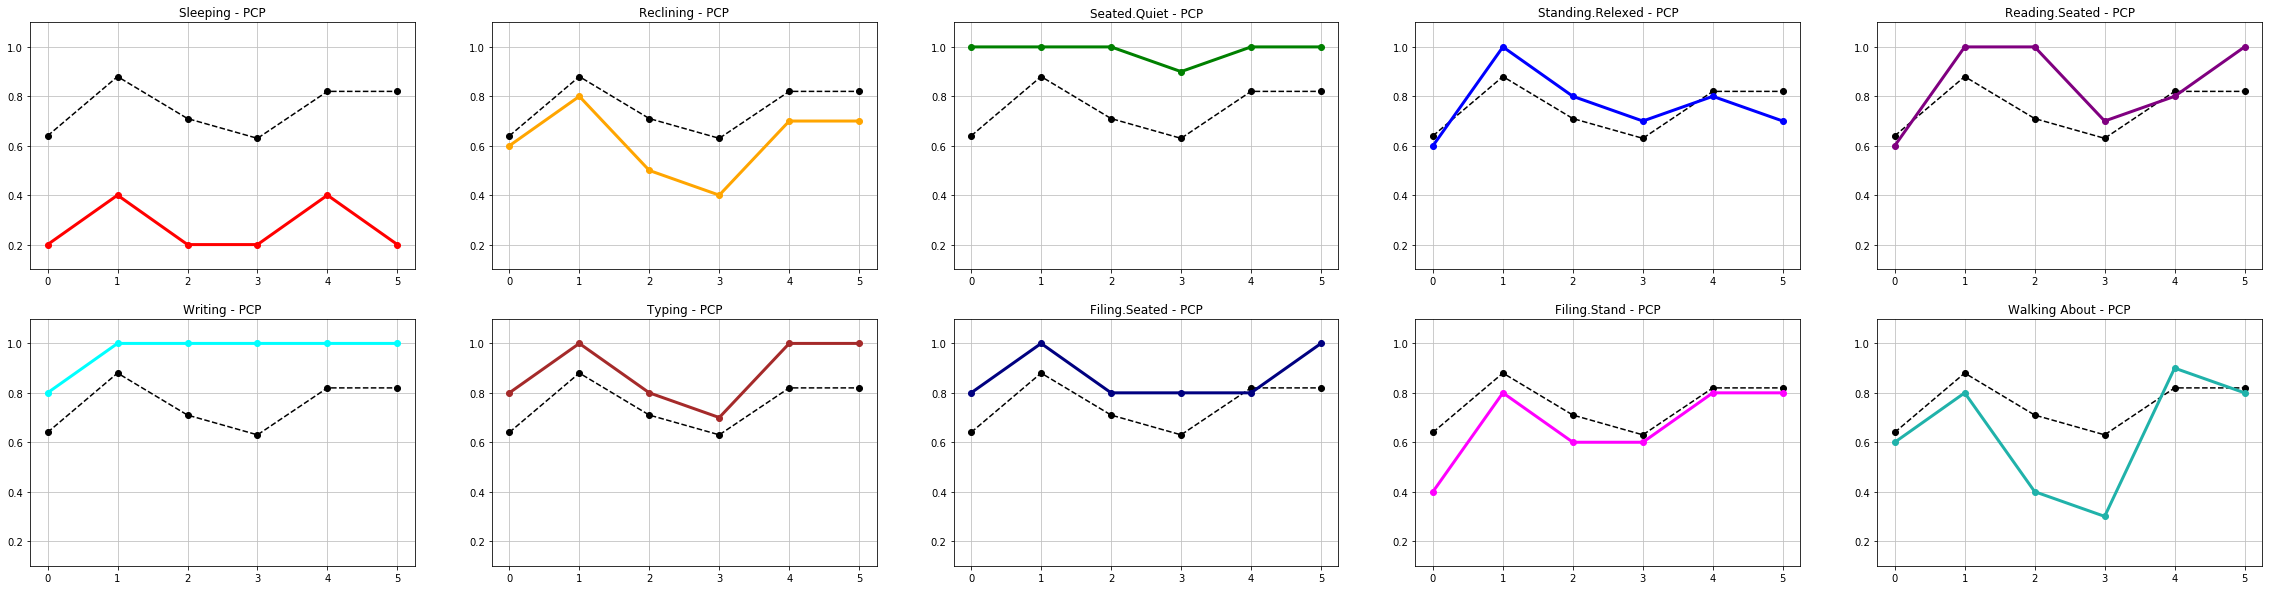

In [7]:
classes = ['Sleeping','Reclining','Seated.Quiet','Standing.Relexed','Reading.Seated',
           'Writing','Typing','Filing.Seated','Filing.Stand','Walking About']

fig, points = plt.subplots(2,5)
fig.set_size_inches(40, 10)

for idx in range(len(classes)):
    points[idx//5][idx%5].set_title(classes[idx]+' - PCP')
    points[idx//5][idx%5].plot(pcp_result[-1,:-1], marker='o',c='black',linestyle='--')
    points[idx//5][idx%5].set_ylim([0.1,1.1])
    points[idx//5][idx%5].plot(pcp_result[idx,:-1], marker='o',c=class_color[idx], linewidth=3)
    points[idx//5][idx%5].grid(b=True, which='major',c='silver')

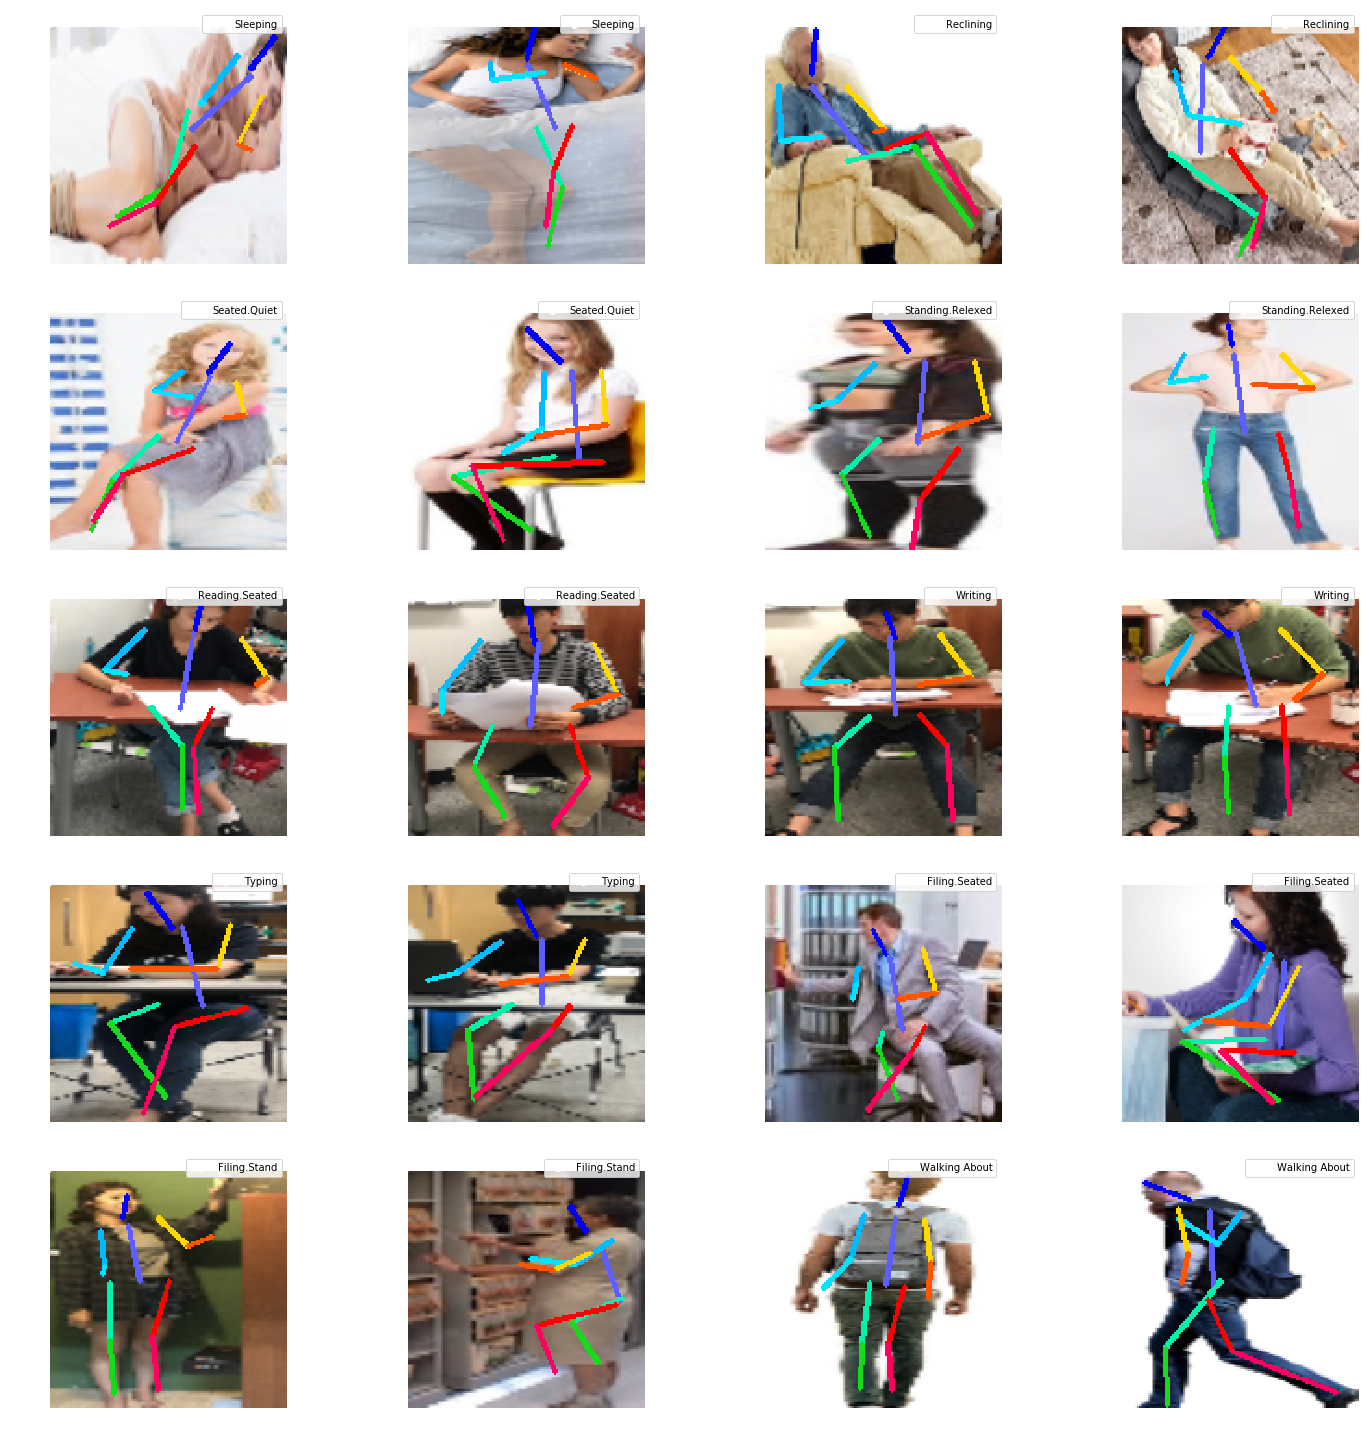

In [8]:
class_pred_result = [[] for i in range(10)]

for i, label in enumerate(test_it.labels.squeeze()):
    img=orig_img_set[i].copy()
    img=tools.etc.drawSticks(img,pred_canonical[i]['sticks'])
    class_pred_result[test_it.labels.squeeze()[i]].append(img)
    
class_pred_result=np.array(class_pred_result)[:,[2,3]].reshape(-1,128,128,3)

fig, pred_fig = plt.subplots(5,4)
fig.set_size_inches(20,20)
plt.tight_layout()

for idx, img in enumerate(class_pred_result):
    pred_fig[idx//4][idx%4].imshow(img[:,:,[2,1,0]])
    pred_fig[idx//4][idx%4].axis('off')
    pred_fig[idx//4][idx%4].scatter(-2,-2, c='white')
    pred_fig[idx//4][idx%4].legend([classes[idx//2]], loc=1)

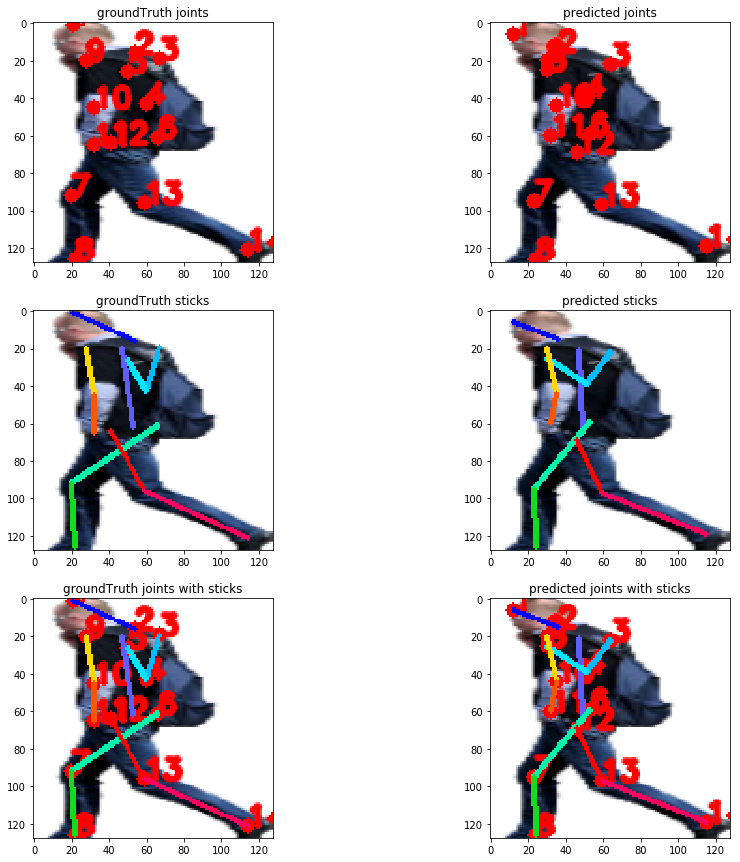

In [9]:
idx=35
tools.etc.demo_plot(orig_img_set[idx], orig_canonical[idx], pred_canonical[idx])